## **Llama 2 for cause prediction**

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [2]:
from accelerate import Accelerator

In [3]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
)
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#### **Define Prompt Template**

**Prompt template:**

\<s>[INST] \<\<SYS>>

{{system message}}

\<\</SYS>>

{{message/input}} [/INST] {{answer}} \</s>

<hr>



#### Sample training prompt with emotion labels
```
<s>[INST]

"conversation": [
            {
                "utterance_ID": 1,
                "text": "Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .",
                "speaker": "Chandler",
                "emotion": "neutral",
                "video_name": "dia1utt1.mp4"
            },
            {
                "utterance_ID": 2,
                "text": "Oh , yeah . Had that dream .",
                "speaker": "All",
                "emotion": "neutral",
                "video_name": "dia1utt2.mp4"
            },
            {
                "utterance_ID": 3,
                "text": "Then I look down , and I realize there is a phone ... there .",
                "speaker": "Chandler",
                "emotion": "surprise",
                "video_name": "dia1utt3.mp4"
            },
            {
                "utterance_ID": 4,
                "text": "Instead of ... ?",
                "speaker": "Joey",
                "emotion": "surprise",
                "video_name": "dia1utt4.mp4"
            },
            {
                "utterance_ID": 5,
                "text": "That is right .",
                "speaker": "Chandler",
                "emotion": "anger",
                "video_name": "dia1utt5.mp4"
            },
            {
                "utterance_ID": 6,
                "text": "Never had that dream .",
                "speaker": "Joey",
                "emotion": "neutral",
                "video_name": "dia1utt6.mp4"
            },
            {
                "utterance_ID": 7,
                "text": "No .",
                "speaker": "Phoebe",
                "emotion": "neutral",
                "video_name": "dia1utt7.mp4"
            },
            {
                "utterance_ID": 8,
                "text": "All of a sudden , the phone starts to ring .",
                "speaker": "Chandler",
                "emotion": "neutral",
                "video_name": "dia1utt8.mp4"
            }
        ]
Identify the cause utterances of the emotion in utterance 5. Output in one line the ids of the cause utterances as a list in the given format:
utterance_id :: [cause utterance ids]
Don't give any explanation.
[/INST]
utterance_id :: [1,3,4]
</s>
```

#### **Preprocess the Input**

In [5]:
with_labels = True

In [6]:
def get_prompt_without_output(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the cause utterances of the emotion in utterance {}. Output in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n"""

In [7]:
def get_prompt_with_output(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the cause utterances of the emotion in utterance {}. Output in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n""", f"""utterance_ids :: {sample_data_point['causes_label']}\n</s>"""


In [8]:
def get_formatted_conversation(data_sample, speaker=False, video=False, audio=False):
    conversation_str = '"conversation": [\n'
    for utt in data_sample["conversation"]:
        conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"emotion\": {}\n}}\n".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["emotion"])
    return conversation_str

In [9]:
def get_causes_list_str(cause_list):
    str_out = "["
    i = 0
    while i < len(cause_list):
        if i == len(cause_list)-1:
            str_out += str(cause_list[i])
        else:
            str_out += str(cause_list[i]) + ","
        i += 1
    str_out += "]"
    return str_out

In [10]:
def form_input(data_sample, utt_id, speaker=False, video=False, audio=False):
    conversation_str = get_formatted_conversation(data_sample, speaker, video, audio)
    emotions_str = data_sample["conversation"][utt_id]["emotion"]
    if with_labels:
        causes_list_str = get_causes_list_str(data_sample["conversation"][utt_id]["cause_list"])

    sample_data_point = {} # has utterance_id, conversation, emotion_label, conv id

    sample_data_point["utterance_id"] = utt_id+1
    sample_data_point["conversation"] = conversation_str
    sample_data_point["emotion_label"] = emotions_str
    if with_labels:
        sample_data_point["causes_label"] = causes_list_str
    sample_data_point["causes_list"] = data_sample["conversation"][utt_id]["cause_list"]
    sample_data_point["conversation_id"] = data_sample["conversation_ID"]
    return sample_data_point


In [11]:
def generate_inst_for_each_utt_of_conv(data_point, speaker=False, video=False, audio=False):
    num_utt = len(data_point["conversation"])
    list_output_objects = []
    for i in range(num_utt):
        sample_data_point = form_input(data_point, i, speaker, video, audio)
        if with_labels:
            inst, out = get_prompt_with_output(sample_data_point, speaker, video, audio)
        else:
            inst = get_prompt_without_output(sample_data_point, speaker, video, audio)
        if with_labels:
            obj = {
                "instruction": inst,
                "out": out,
                "text": inst + out,
                "emotion_label": sample_data_point["emotion_label"],
                "utterance_id": sample_data_point["utterance_id"],
                "conversation_id": sample_data_point["conversation_id"],
                "causes_label":sample_data_point["causes_label"],
                "causes_list":sample_data_point["causes_list"]
            }
        else:
            obj = {
                "instruction": inst,
                # "out": out,
                # "text": inst + out,
                "emotion_label": sample_data_point["emotion_label"],
                "utterance_id": sample_data_point["utterance_id"],
                "conversation_id": sample_data_point["conversation_id"],
                # "causes_label":sample_data_point["causes_label"],
                # "causes_list":sample_data_point["causes_list"]
            }
        list_output_objects.append(obj)
    return list_output_objects

In [12]:
def process_dataset(data, speaker=False, video=False, audio=False):
    flattened_list = [element for sublist in map(lambda x: generate_inst_for_each_utt_of_conv(x, speaker, video, audio), data) for element in sublist]
    ds = {}
    # IMP: only include those utterances in dataset where emotion is not "neutral", we will only find cause list for those
    ds["instruction"] = [sample["instruction"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["emotion_label"] = [sample["emotion_label"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["utterance_id"] = [sample["utterance_id"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["conversation_id"] = [sample["conversation_id"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    if with_labels:
        ds["causes_label"] = [sample["causes_label"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["causes_list"] = [sample["causes_list"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["out"] = [sample["out"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["text"] = [sample["text"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    return ds

In [13]:
from sklearn.model_selection import train_test_split

def create_json(data, save_folder, speaker=False, video=False, audio=False):

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    else:
        print("Input already present at {}\n".format(save_folder))
        conv_file = os.path.join(save_folder, "conversations.json")
        return conv_file

    # create a map for storing cause_list for each utt of each conv
    # map of map
    cause_map = {}
    for conv in data:
        conv_id = conv["conversation_ID"]
        cause_map[conv_id] = {}
        for pair in conv["emotion-cause_pairs"]:
            emo_id = int(pair[0].split('_')[0])
            cau_id = int(pair[1])
            if emo_id in cause_map[conv_id].keys():
                cause_map[conv_id][emo_id].append(cau_id)
            else:
                cause_map[conv_id][emo_id] = [cau_id]
    # Now go through utt and add their "cause_list", could be [] for neutral
    for conv in data:
        conv_id = conv["conversation_ID"]
        if conv_id not in cause_map.keys():
            for utt in conv["conversation"]:
                utt["cause_list"] = []
        else:
            for utt in conv["conversation"]:
                utt_id = utt["utterance_ID"]
                if utt_id not in cause_map[conv_id].keys():
                    utt["cause_list"] = []
                else:
                    utt["cause_list"] = cause_map[conv_id][utt_id]


    print("Number of conversations in dataset: {}".format(len(data)))

    conv_file = os.path.join(save_folder, "conversations.json")
    with open(conv_file, 'w') as f:
        json.dump(data, f)
    return conv_file

def generate_input(args):
    text_folder = os.path.join("data")
    save_dir = os.path.join("input")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(text_folder, "Subtask_2_2_train.json")
    file = open(file_path)
    data = json.load(file)

    data_trainval, data_test = train_test_split(data, test_size=0.1, random_state=args.seed)
    data_train, data_val = train_test_split(data_trainval, test_size=0.1, random_state=args.seed)

    save_folder_test = os.path.join(save_dir, 'test')
    save_folder_train = os.path.join(save_dir, 'train')
    save_folder_val = os.path.join(save_dir, 'val')

    test_file = create_json(data_test, save_folder_test, args.speaker, args.video, args.audio)
    train_file = create_json(data_train, save_folder_train, args.speaker, args.video, args.audio)
    val_file = create_json(data_val, save_folder_val, args.speaker, args.video, args.audio)
    return test_file, train_file, val_file


In [14]:
# Params
class Config:
    def __init__(self) -> None:
        self.seed = 42
        self.speaker = True
        self.video = False
        self.audio = False

In [15]:
train_data = []
test_data = []
val_data = []

In [16]:
config = Config()
from datasets import Dataset

if with_labels:
    test_file, train_file, val_file = generate_input(config)

    with open(train_file, 'r') as f:
        train_data = json.load(f)
    with open(val_file, 'r') as f:
        val_data = json.load(f)
    with open(test_file, 'r') as f:
        test_data = json.load(f)

    print(len(train_data))
    print(len(test_data))
    print(len(val_data))
    train_data = train_data[:400]
    val_data = val_data[:30]
    test_data = test_data

    # Form datasets from data
    train_dataset = process_dataset(train_data, speaker=config.speaker, video=config.video)
    val_dataset = process_dataset(val_data, speaker=config.speaker, video=config.video)
    test_dataset = process_dataset(test_data, speaker=config.speaker, video=config.video)

    train_dataset = Dataset.from_dict(train_dataset)
    val_dataset = Dataset.from_dict(val_dataset)
    test_dataset = Dataset.from_dict(test_dataset)

    print("Train len {}".format(len(train_dataset)))
    print("Test len {}".format(len(test_dataset)))
    print("Val len {}".format(len(val_dataset)))
    dataset = train_dataset
else:
    with open("./emotion_labelled_data.json", 'r') as f:
        data = json.load(f)
        dataset = process_dataset(data, speaker=config.speaker, video=config.video)
        dataset = Dataset.from_dict(dataset)
        print("len {}".format(len(dataset["instruction"])))

Number of conversations in dataset: 138
Number of conversations in dataset: 1112
Number of conversations in dataset: 124
1112
138
124
Train len 2304
Test len 778
Val len 149


### 3. Fine-tune Llama 2 using QLoRA
[QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

In [17]:
print(dataset["text"][0])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
"emotion": joy
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
"emotion": neutral
}
Identify the cause utterances of the emotion in utterance 1. Output in one line the ids of the cause utterances as a list in the given format:
u

In [18]:
# Can't Load the model on a 4GB or even 16GB GPU, so use accelerate for automatically creating device map
import accelerate

In [19]:
model_id = "meta-llama/Llama-2-13b-chat-hf"

In [20]:
# Paste write token
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credent

In [21]:
model_config = AutoConfig.from_pretrained(model_id)

with accelerate.init_empty_weights():
    fake_model = AutoModelForCausalLM.from_config(model_config)

device_map=accelerate.infer_auto_device_map(fake_model, max_memory={0: "3GiB", "cpu": "6GiB"}) #
print(json.dumps(device_map, indent=4))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

{
    "model.embed_tokens": 0,
    "model.layers.0": 0,
    "model.layers.1.self_attn": 0,
    "model.layers.1.input_layernorm": "cpu",
    "model.layers.1.post_attention_layernorm": "cpu",
    "model.layers.2": "cpu",
    "model.layers.3": "cpu",
    "model.layers.4": "cpu",
    "model.layers.5.self_attn": "cpu",
    "model.layers.5.mlp.gate_proj": "cpu",
    "model.layers.5.mlp.up_proj": "cpu",
    "model.layers.5.mlp.down_proj": "disk",
    "model.layers.5.mlp.act_fn": "disk",
    "model.layers.5.input_layernorm": "disk",
    "model.layers.5.post_attention_layernorm": "disk",
    "model.layers.6": "disk",
    "model.layers.7": "disk",
    "model.layers.8": "disk",
    "model.layers.9": "disk",
    "model.layers.10": "disk",
    "model.layers.11": "disk",
    "model.layers.12": "disk",
    "model.layers.13": "disk",
    "model.layers.14": "disk",
    "model.layers.15": "disk",
    "model.layers.16": "disk",
    "model.layers.17": "disk",
    "model.layers.18": "disk",
    "model.laye

In [22]:
# Use 4-bit quantized version of model, wgts and activations -> 4 bits
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", # 4-bit quantized noraml float
    bnb_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [23]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"": Accelerator().local_process_index},
                                             offload_folder="/tmp/.offload",
                                             low_cpu_mem_usage=True,
                                             torch_dtype=torch.float16,
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

#### **Zero Shot Inference**

In [24]:
index = 0
prompt = test_dataset["instruction"][index]
print(prompt)

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        input_ids=inputs["input_ids"],
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE OUTPUT:\n{train_dataset["out"][index]}')
print(dash_line)
print(f'MODEL OUTPUT (ZERO SHOT):\n{output}')
print(dash_line)

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know y

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker":

#### **Analyzing the tokens**

The maximum context length for Llama is 4096.

In [ ]:
#Tokenize each row in the Instruction and Out Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(test_dataset["instruction"][i])) for i in range(len(train_dataset["instruction"][:50]))]
print("Instruction Tokens Count", instruction_tokens_count[:10])
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Instruction Tokens Count [785, 785, 785, 785, 785, 786, 786, 786, 516, 516]
Length of Instruction Tokens Count 50


In [ ]:
out_tokens_count = [len(tokenizer.tokenize(test_dataset["out"][i])) for i in range(len(train_dataset["out"][:50]))]
print("out Tokens Count", out_tokens_count[:10])
print("Length of out Tokens Count", len(out_tokens_count))

out Tokens Count [10, 10, 10, 12, 8, 11, 14, 11, 8, 10]
Length of out Tokens Count 50


In [ ]:
combine_tokens_count = [i + o for i, o in zip(instruction_tokens_count, out_tokens_count)]
print("out Tokens Count", combine_tokens_count[:10])
print("Length of out Tokens Count", len(combine_tokens_count))

out Tokens Count [795, 795, 795, 797, 793, 797, 800, 797, 524, 526]
Length of out Tokens Count 50


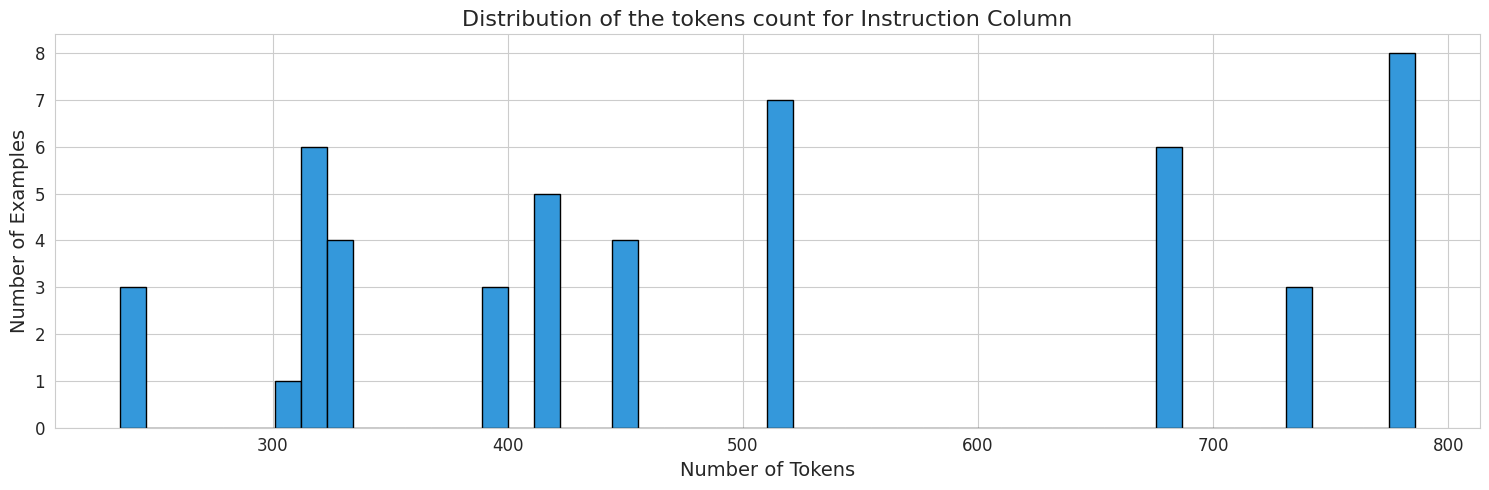

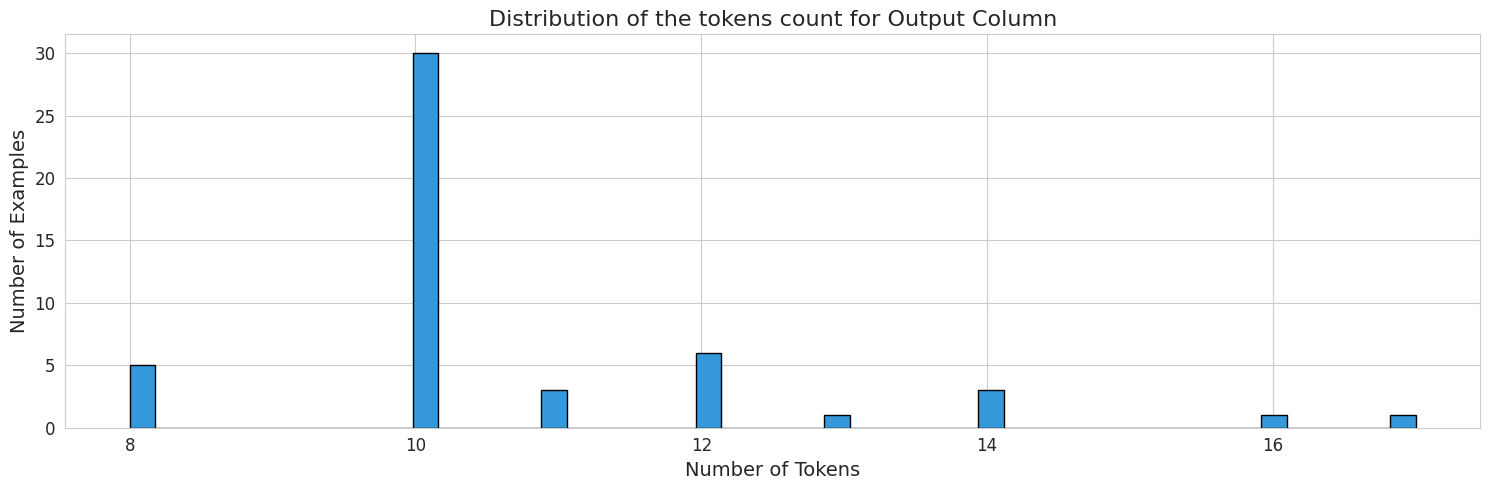

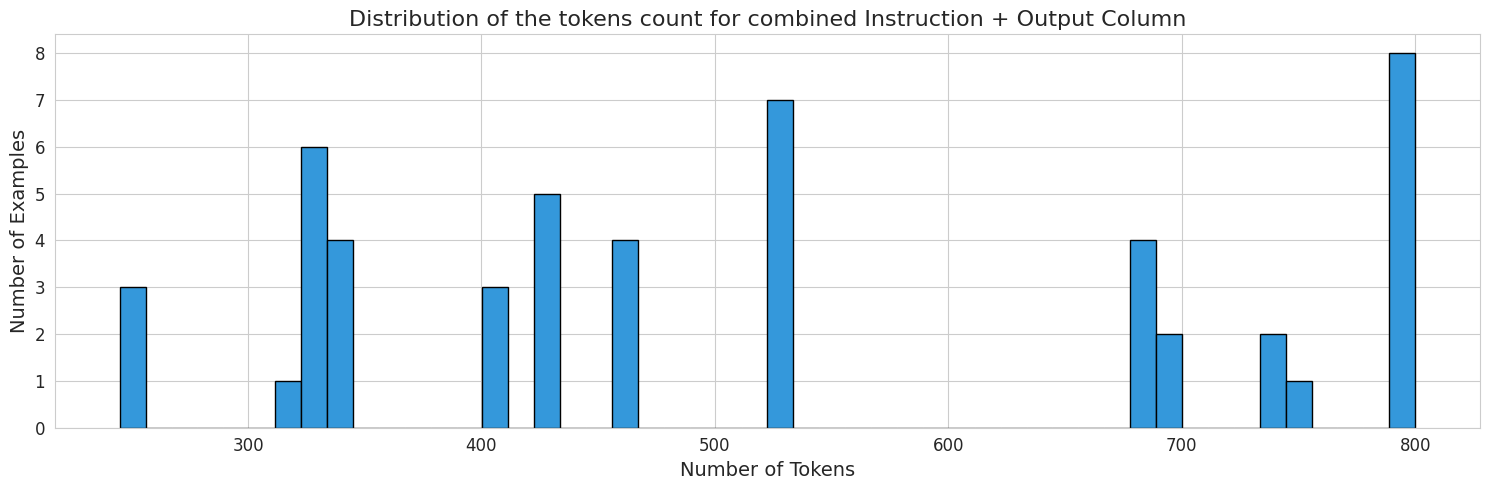

In [ ]:
# Create a histogram using the matplotlib to see the distribution of our token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
# Output Tokens Count
plot_distribution(out_tokens_count, "Distribution of the tokens count for Output Column")
# Combined Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
# The mean is around 600 tokens for combined instruction and output

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
# With quantization memory footprint is reduced to nearly 11 Gb from 25 GB for llama 7b
print(f"Memory footprint in bytes: {model.get_memory_footprint()}")

Memory footprint in bytes: 7083970560


In [ ]:
print(json.dumps(model.hf_device_map, indent=4))

{
    "": 0
}


### 4. Training Setup

Using peft library for Parameter Efficient Fine-Tuning

In [25]:
output_dir="./results"
num_train_epochs=1
per_device_train_batch_size=1
gradient_accumulation_steps=8
optim="paged_adamw_32bit"
save_steps=200
logging_steps=1
learning_rate=2e-3
weight_decay=0.001
fp16=True
bf16=False
max_grad_norm=0.3
max_steps=-1
warmup_ratio=0.03
group_by_length=True
lr_scheduler_type="cosine" #cosine
report_to="wandb"
seed=42
evaluation_strategy="steps"
eval_steps=250

In [26]:
# wandb config


wandb_config = {
    "speaker":config.speaker,
    "video":config.video,
    "audio":config.audio,
    "lr":learning_rate,
    "epochs":num_train_epochs,
    "llama-model":13,
}

run = wandb.init(project="llm-mecpe", entity='arefa2001', name="13b-cause-train", config=wandb_config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'Trainable parameters: {trainable_params} | All params: {all_params} | Trainable%: {trainable_params*100.0/all_params}'
    )
model.config.use_cache = False # silence warnings, enable for inferencing

In [28]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [29]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16, # alpha scaling
    lora_dropout=0.1,
    r=16, # attention_heads
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM", # or for seq2seq
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

Trainable parameters: 26214400 | All params: 6698193920 | Trainable%: 0.391365199531279


In [30]:
# Load training arguments
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_32bit",
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type, #cosine
    report_to="wandb",
    seed=config.seed,
    evaluation_strategy="steps",
    eval_steps=eval_steps
)

### 5. Supervised Fine Tuning using SFTTrainer

Using SFTTrainer from TRL library that gives a wrapper around transformers ```Trainer``` to easily fine-tune models on instruction based datasets using PEFT adapters.

In [31]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    # max_seq_length=4096,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/2304 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

In [32]:
# train for fewer epochs
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
250,0.482200,0.750700


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=288, training_loss=0.5435833229372898, metrics={'train_runtime': 14638.3544, 'train_samples_per_second': 0.157, 'train_steps_per_second': 0.02, 'total_flos': 1.1644974794161152e+17, 'train_loss': 0.5435833229372898, 'epoch': 1.0})

In [33]:
def save_peft_model(save_folder, speaker=False, video=False, audio=False):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trainer.save_model(save_folder) # does not save the whole model, only the checkpoint
    return save_folder

In [34]:
peft_model_path="./saved-peft-model"
peft_model_folder = save_peft_model(peft_model_path, config.speaker, config.video, config.audio)

In [35]:
torch.save(trainer.model.state_dict(), f"{peft_model_path}/adapter_model.bin")

#### **Push model to huggingface hub**

In [ ]:
# # Merge LoRA and base model
# merged_model = model.merge_and_unload()

# # Save the merged model
# merged_model.save_pretrained("saved_model",safe_serialization=True)
# tokenizer.save_pretrained("saved_model")

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:229: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/tokenizer.json')

In [36]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [37]:
from huggingface_hub import create_repo
create_repo("ArefaMuzaffar/merged-llama-cause-text-new", token="hf_iOSdn", private=True)

RepoUrl('https://huggingface.co/ArefaMuzaffar/merged-llama-cause-text-new', endpoint='https://huggingface.co', repo_type='model', repo_id='ArefaMuzaffar/merged-llama-cause-text-new')

In [39]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [40]:
from huggingface_hub import upload_folder
upload_folder(repo_id="ArefaMuzaffar/merged-llama-cause-text-new", folder_path="saved-peft-model")

adapter_model.bin:   0%|          | 0.00/7.96G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/105M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArefaMuzaffar/merged-llama-cause-text-new/commit/a3e6b24e5bf9f6165698e87803aafa89fd566e55', commit_message='Upload folder using huggingface_hub', commit_description='', oid='a3e6b24e5bf9f6165698e87803aafa89fd566e55', pr_url=None, pr_revision=None, pr_num=None)

#### **Evaluation on Test Data**

In [41]:
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(i

In [42]:
print(test_dataset[0]["text"])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know y

#### **Inference**

In [44]:
with open("./data/Subtask_2_2_train.json", 'r') as f:
    data = json.load(f)
    data = data[-80:-30]

    # create a map for storing cause_list for each utt of each conv
    # map of map
    cause_map = {}
    for conv in data:
        conv_id = conv["conversation_ID"]
        cause_map[conv_id] = {}
        for pair in conv["emotion-cause_pairs"]:
            emo_id = int(pair[0].split('_')[0])
            cau_id = int(pair[1])
            if emo_id in cause_map[conv_id].keys():
                cause_map[conv_id][emo_id].append(cau_id)
            else:
                cause_map[conv_id][emo_id] = [cau_id]
    # Now go through utt and add their "cause_list", could be [] for neutral
    for conv in data:
        conv_id = conv["conversation_ID"]
        if conv_id not in cause_map.keys():
            for utt in conv["conversation"]:
                utt["cause_list"] = []
        else:
            for utt in conv["conversation"]:
                utt_id = utt["utterance_ID"]
                if utt_id not in cause_map[conv_id].keys():
                    utt["cause_list"] = []
                else:
                    utt["cause_list"] = cause_map[conv_id][utt_id]

    dataset = process_dataset(data, speaker=config.speaker, video=config.video)
    dataset = Dataset.from_dict(dataset)
    print("len {}".format(len(dataset["instruction"])))

len 329


In [45]:
# Define folder for saving the output
if with_labels:
    eval_results_folder = "./results_train"
    if not os.path.exists(eval_results_folder):
        os.makedirs(eval_results_folder)
else:
    eval_results_folder = "./results_test"
    if not os.path.exists(eval_results_folder):
        os.makedirs(eval_results_folder)

In [46]:
# if with_labels:
    # dataset = test_dataset
n = len(dataset["instruction"])

In [47]:
# Dataloader for batched inference
from torch.utils.data import Dataset, DataLoader
class InferenceDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset["instruction"])

    def __getitem__(self, idx):
        instruction = self.dataset["instruction"][idx]

        return instruction

In [48]:
# Get full output for entire dataset, batched inference
def get_full_output_batched(dataset, batch_size=1):
    init_time = time.time()
    inference_dataset = InferenceDataset(dataset, tokenizer)

    data_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

    outputs_list = []

    model.eval()
    i = 0
    with torch.no_grad():
        for batch_item in data_loader:
            start_time = time.time()
            instructions = batch_item
            print("------------------------------------")
            print(f"Iteration {i}")
            print("------------------------------------")
            i += 1
            tokenized_instruction = tokenizer(instructions, return_tensors="pt", padding=True, truncation=True, max_length=3000)
            input_ids = tokenized_instruction["input_ids"].cuda()

            outputs = model.generate(input_ids=input_ids, max_new_tokens=30) # max_new_tokens is to limit the num of tokens added to orig input
            # since we only want to add utterance_ids :: [1,2,3,4,5] we may set it to 30

            decoded_outputs = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)
            end_time = time.time()
            print("Inference time for one sample: {:.2f} seconds".format((end_time - start_time)/batch_size))
            outputs_list.extend(decoded_outputs)
    final_time = time.time()
    print("Total time for {} samples using batched inferencing = {} seconds.".format(n, final_time - init_time))
    return outputs_list

In [49]:
preds_list = []
true_list = []
full_output = []

In [50]:
init_time = time.time()
full_output = get_full_output_batched(dataset, 1)
final_time = time.time()

print("Total time for {} samples = {} seconds.".format(n, final_time - init_time))

------------------------------------
Iteration 0
------------------------------------
Inference time for one sample: 14.49 seconds
------------------------------------
Iteration 1
------------------------------------
Inference time for one sample: 12.74 seconds
------------------------------------
Iteration 2
------------------------------------
Inference time for one sample: 13.18 seconds
------------------------------------
Iteration 3
------------------------------------
Inference time for one sample: 13.53 seconds
------------------------------------
Iteration 4
------------------------------------
Inference time for one sample: 13.05 seconds
------------------------------------
Iteration 5
------------------------------------
Inference time for one sample: 13.83 seconds
------------------------------------
Iteration 6
------------------------------------
Inference time for one sample: 12.79 seconds
------------------------------------
Iteration 7
----------------------------------

In [51]:
def extract_cause_list(output):
    lst = output.split('::')
    if len(lst) >= 3:
        output = lst[2]
    else:
        output = lst[0]
    lst = output.split('[')
    if len(lst) >= 2:
        output = lst[1]
    else:
        output = lst[0]
    output = output.strip()
    lst = output.split(']')
    output = lst[0].strip()
    output = output.split(',')
    final = []
    for string in output:
        final.append(int(string))
    return final

In [52]:
pred_causes_map = {}
def evaluate_with_label_batched(dataset):
    # extract the list from text, !without shuffle
    for i in range(len(dataset["instruction"])):
        print("------------------------------------")
        print(f"Iteration {i}")
        print("------------------------------------")
        output = full_output[i] # of the form: utterance_ids :: [1,2] or []
        # extract
        output = extract_cause_list(output.strip())
        print("Predicted: ", output)
        preds_list.append(output)
        # baseline
        baseline_output = dataset["causes_list"][i]
        print("Baseline: ", baseline_output)
        true_list.append(baseline_output)

        # Update map
        conv_id = dataset["conversation_id"][i]
        utt_id = dataset["utterance_id"][i]
        if conv_id not in pred_causes_map.keys():
            pred_causes_map[conv_id] = {}
        pred_causes_map[conv_id][utt_id] = output



In [53]:
def evaluate_without_label_batched(dataset):

    # extract the label from text, !without shuffle
    for i in range(len(dataset["instruction"])):
        print("------------------------------------")
        print(f"Iteration {i}")
        print("------------------------------------")
        output = full_output[i] # of the form: utterance_ids :: [1,2] or []
        # extract
        output = extract_cause_list(output.strip())
        print("Predicted: ", output)
        preds_list.append(output)

        # Update map
        conv_id = dataset["conversation_id"][i]
        utt_id = dataset["utterance_id"][i]
        if conv_id not in pred_causes_map.keys():
            pred_causes_map[conv_id] = {}
        pred_causes_map[conv_id][utt_id] = output

In [54]:
if with_labels:
    evaluate_with_label_batched(dataset)
else:
    evaluate_without_label_batched(dataset)

------------------------------------
Iteration 0
------------------------------------
Predicted:  [1]
Baseline:  [1]
------------------------------------
Iteration 1
------------------------------------
Predicted:  [3]
Baseline:  [1, 2, 3]
------------------------------------
Iteration 2
------------------------------------
Predicted:  [3]
Baseline:  [4]
------------------------------------
Iteration 3
------------------------------------
Predicted:  [5]
Baseline:  [4, 5]
------------------------------------
Iteration 4
------------------------------------
Predicted:  [8, 9]
Baseline:  [9]
------------------------------------
Iteration 5
------------------------------------
Predicted:  [13]
Baseline:  [13]
------------------------------------
Iteration 6
------------------------------------
Predicted:  [13, 14]
Baseline:  [14]
------------------------------------
Iteration 7
------------------------------------
Predicted:  [15]
Baseline:  [14]
------------------------------------
Itera

In [56]:
# Save results
with open(eval_results_folder + "/pred_text_batched.json", 'w', encoding="utf-8") as f:
    for string in full_output:
        f.write(f"{string}\n[/NEWNEW]\n")
with open(eval_results_folder + "/pred_list_batched.json", 'w', encoding="utf-8") as f:
    for i in range(len(preds_list)):
        f.write(f'{preds_list[i]}\n')
if with_labels:
    with open(eval_results_folder + "/true_list_batched.json", 'w', encoding="utf-8") as f:
        for i in range(len(true_list)):
            f.write(f'{true_list[i]}\n')
# Save dict
with open(eval_results_folder + "/pred_causes_map.json", 'w', encoding="utf-8") as f:
    json.dump(pred_causes_map, f)


#### **Add "emotion-cause_pairs" key to original dict for submission**

The format for pairs within each conversation is:

```
"emotion-cause_pairs": [
            [
                "3_surprise",
                "1"
            ],
            [
                "3_surprise",
                "3"
            ],
            [
                "4_surprise",
                "1"
            ],
            [
                "4_surprise",
                "3"
            ],
            [
                "4_surprise",
                "4"
            ],
            [
                "5_anger",
                "1"
            ],
            [
                "5_anger",
                "3"
            ],
            [
                "5_anger",
                "4"
            ]
        ]
```

In [ ]:
# Load data

In [60]:
for conv in data:
    conv_id = conv["conversation_ID"]
    conv["emotion-cause_pairs"] = []
    if conv_id not in pred_causes_map.keys():
        continue
    for utt_id, lst in pred_causes_map[conv_id].items():
        ff = str(utt_id)+"_"+conv["conversation"][utt_id - 1]["emotion"]
        for cause_id in lst:
            ss = str(cause_id)
            conv["emotion-cause_pairs"].append([ff, ss])
            print("Added pair: {}".format([ff, ss]))

Added pair: ['1_anger', '1']
Added pair: ['3_disgust', '3']
Added pair: ['4_surprise', '3']
Added pair: ['5_joy', '5']
Added pair: ['9_sadness', '8']
Added pair: ['9_sadness', '9']
Added pair: ['13_sadness', '13']
Added pair: ['14_joy', '13']
Added pair: ['14_joy', '14']
Added pair: ['15_surprise', '15']
Added pair: ['1_surprise', '1']
Added pair: ['7_anger', '6']
Added pair: ['10_disgust', '9']
Added pair: ['10_disgust', '10']
Added pair: ['11_disgust', '11']
Added pair: ['12_anger', '11']
Added pair: ['12_anger', '12']
Added pair: ['13_anger', '13']
Added pair: ['14_anger', '12']
Added pair: ['14_anger', '13']
Added pair: ['14_anger', '14']
Added pair: ['16_anger', '14']
Added pair: ['16_anger', '15']
Added pair: ['1_anger', '1']
Added pair: ['2_sadness', '2']
Added pair: ['3_joy', '2']
Added pair: ['4_joy', '3']
Added pair: ['4_joy', '4']
Added pair: ['5_joy', '4']
Added pair: ['6_joy', '5']
Added pair: ['6_joy', '6']
Added pair: ['8_surprise', '8']
Added pair: ['9_joy', '9']
Added 

In [61]:
with open(eval_results_folder + "/pair_labelled_data.json", 'w', encoding="utf-8") as f:
    json.dump(test_data, f)

In [62]:
# If you want to download the checkpoints
from google.colab import files
import os

dir_to_zip = eval_results_folder #@param {type: "string"}
output_filename = 'cause_test_subset_results.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
# Merge LoRA and base model
merged_model = model.merge_and_unload()

# Save the merged model
model.save_pretrained("saved_model",safe_serialization=True)
tokenizer.save_pretrained("saved_model")
torch.save(trainer.model.state_dict(), f"saved_model/adapter_model.bin")

In [67]:
from huggingface_hub import create_repo
create_repo("ArefaMuzaffar/merged-llama-cause-text2", token="hf_iOSDMuKsS", private=True)

RepoUrl('https://huggingface.co/ArefaMuzaffar/merged-llama-cause-text2', endpoint='https://huggingface.co', repo_type='model', repo_id='ArefaMuzaffar/merged-llama-cause-text2')

In [68]:
from huggingface_hub import upload_folder
upload_folder(repo_id="ArefaMuzaffar/merged-llama-cause-text2", folder_path="saved_model")

adapter_model.safetensors:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/7.86G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArefaMuzaffar/merged-llama-cause-text2/commit/e4c6b48f9a0d2b490a8117d0a9729af5bec19cc9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e4c6b48f9a0d2b490a8117d0a9729af5bec19cc9', pr_url=None, pr_revision=None, pr_num=None)